In [19]:
%matplotlib inline
from ipywidgets import interact, FloatSlider, HTML
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=18)
import numpy as np
import warnings


from hyperfet.devices import SCMOSFET,VO2,HyperFET, Direction
import hyperfet.approximations as appr
import hyperfet.extractions as extr
from hyperfet.references import si, mixed_vo2_params
from hyperfet.fitting import show_transistor

In [20]:
def ylog():
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        plt.yscale('log')

In [21]:
# Parameters given for Figure 3

#vo2_params={
#    "rho_m":si("5e-4 ohm cm"),
#    "rho_i":si("80 ohm cm"),
#    "J_MIT":si("2e6 A/cm^2"),
#    "J_IMT":si(".55e4 A/cm^2"),
#    "V_met":0,
#    "L":si("8nm"),
#    "W":si("14nm"),
#    "T":si("14nm")
#}
#vo2=VO2(**vo2_params)

VDD=.5

In [39]:
opts={
    'figsize': (6,7),
    'linidvgpos': [.3,.68,.2,.2],
    'linidvgxticks': [0,.25,.5],
    'linidvgxlim': [0,.5],
    'linidvgyticks': [100,200,300],
    'linidvdpos': [.62,.25,.25,.3],
    'linidvdxticks': [0,.25,.5],
    'linidvdyticks': [0,100,200,300],
}

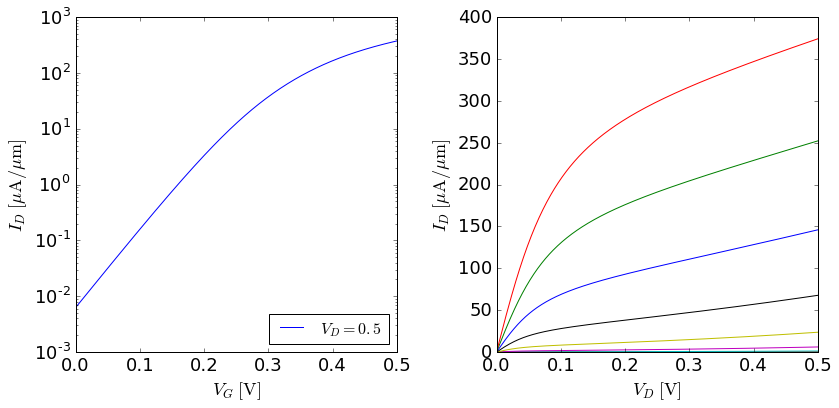

In [41]:
fet=None
@interact(VT0=FloatSlider(value=.4,min=0,max=1,step=.05,continuous_update=False),
          W=FloatSlider(value=100,min=10,max=100,step=10,continuous_update=False),
          Cinv_vxo=FloatSlider(value=2500,min=1000,max=5000,step=400,continuous_update=False),
          SS=FloatSlider(value=.070,min=.05,max=.09,step=.005,continuous_update=False),
          alpha=FloatSlider(value=2.5,min=0,max=5,step=.5,continuous_update=False),
          beta=FloatSlider(value=1.8,min=0,max=4,step=.1,continuous_update=False),
          VDD=FloatSlider(value=.5,min=.3,max=1,step=.05,continuous_update=False),
          VDsats=FloatSlider(value=.1,min=.1,max=2,step=.1,continuous_update=False),
          delta=FloatSlider(value=.1,min=0,max=.5,step=.05,continuous_update=False),
          log10Gleak=FloatSlider(value=-12,min=-14,max=-5,step=1,continuous_update=False)
         )
def show_HEMT(VT0,W,Cinv_vxo,SS,alpha,beta,VDsats,VDD,delta,log10Gleak):
    global fet
    plt.figure(figsize=(12,6))
    fet=SCMOSFET(
        W=W*1e-9,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    
    plt.subplot(121)
    VD=np.array(VDD)
    VG=np.linspace(0,.5,500)
    I=fet.ID(VD=VD,VG=VG)
    plt.plot(VG,I/fet.W,label=r"$V_D={:.2g}$".format(VDD))
    plt.yscale('log')
    plt.xlabel(r"$V_G\;\mathrm{[V]}$")
    plt.ylabel(r"$I_D\;\mathrm{[\mu A/\mu m]}$")
    plt.legend(loc='lower right',fontsize=16)
    
    plt.subplot(122)
    VD=np.linspace(0,VDD,500)
    VG=np.linspace(0,VDD,10)
    I=fet.ID(VD=VD,VG=VG)
    plt.plot(VD,I.T/fet.W)
    plt.xlabel(r"$V_D\;\mathrm{[V]}$")
    plt.ylabel(r"$I_D\;\mathrm{[\mu A/\mu m]}$")
    #plt.legend([r"$V_G={:.2g}$".format(vg) for vg in VG],loc='lower right',fontsize=16)
    
    plt.tight_layout()

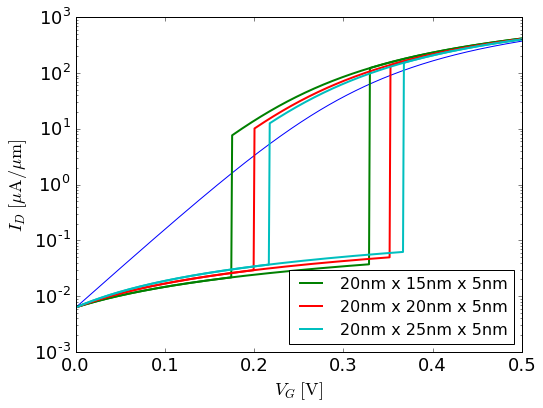

In [5]:
VDD=.5

VD=np.array(VDD)
VG=np.linspace(0,.5,500)

plt.figure(figsize=(8,6))
plt.plot(VG,fet.ID(VD,VG)/fet.W)

for LWT in ["20nm x 15nm x 5nm", "20nm x 20nm x 5nm", "20nm x 25nm x 5nm"]:
    L,W,T=[si(x) for x in LWT.split("x")]
    vo2=VO2(L=L,W=W,T=T,**mixed_vo2_params)
    hf=HyperFET(fet.shifted(appr.shift(HyperFET(fet,vo2),VDD)),vo2)
    
    If,Ib=[np.ravel(i) for i in hf.I_double(VD=VD,VG=VG)]
    l=plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/fet.W,label=LWT,linewidth=2)[0]
    plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/fet.W,linewidth=2,color=l.get_color())
    
plt.yscale('log')
plt.xlabel(r"$V_G\;\mathrm{[V]}$")
plt.ylabel(r"$I_D\;\mathrm{[\mu A/\mu m]}$")
plt.legend(loc='lower right',fontsize=16)

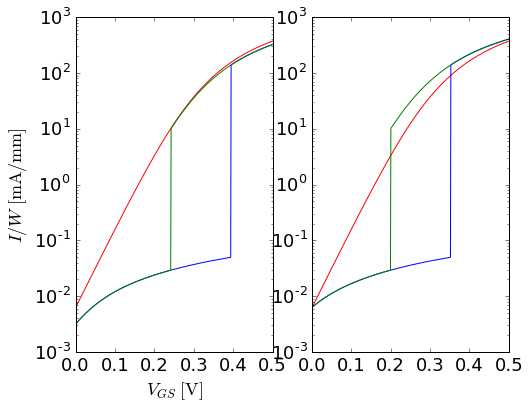

In [6]:
out=HTML()
vo2=None
fet2=None
hf=None
hf2=None
VTm,VTp=[None]*2
@interact(L=FloatSlider(value=20,min=1,max=45,step=1,continuous_update=False),
          W=FloatSlider(value=10,min=.5,max=20,step=.5,continuous_update=False),
          T=FloatSlider(value=10,min=.5,max=20,step=.5,continuous_update=False))
def show_hf(L,W,T):
    global vo2, fet2,VTm,VTp, hf, hf2
    plt.figure(figsize=(12,6))
    
    vo2=VO2(L=L*1e-9,W=W*1e-9,T=T*1e-9,**mixed_vo2_params)
    hf=HyperFET(fet,vo2)
    shift=appr.shift(hf,VDD)
    fet2=fet.shifted(shift)
    hf2=HyperFET(fet2,vo2)
    
    VD=np.array(VDD)
    VG=np.linspace(0,VDD,500)

    plt.subplot(131)
    I=np.ravel(fet.ID(VD=VD,VG=VG))
    plt.plot(VG,I/fet.W,'r')
    
    If,Ib=[np.ravel(i) for i in hf.I_double(VD=VD,VG=VG)]
    plt.plot(VG,If/fet.W,'b')
    plt.plot(VG,Ib/fet.W,'g')
    
    
    
    plt.ylim(1e-3,1e3)
    plt.xlabel("$V_{GS}\;\mathrm{[V]}$")
    plt.ylabel("$I/W\;\mathrm{[mA/mm]}$")
    ylog()
    
    plt.subplot(132)    
    plt.plot(VG,I/fet2.W,'r')
    If2,Ib2=[np.ravel(i) for i in hf2.I_double(VD=VD,VG=VG)]
    plt.plot(VG,If2/fet2.W,'b')
    plt.plot(VG,Ib2/fet2.W,'g')
    
    
    
    plt.ylim(1e-3,1e3)
    plt.yticks([])
    ylog()
    
    out.value="Approx shift is {:.2g}mV, which equates the IOFF within {:.2g}%."\
    "  This is expected to increase ION by {:.2g}% and actually increases it by {:.2g}%"\
    .format(shift*1e3,(If2[0]-I[0])/I[0]*100,appr.shiftedgain(hf,VDD)*100-100,(If2[-1]-I[-1])/I[-1]*100)
    
    _,_,VTm,VTp=appr.shorthands(hf,VDD,None,"VTm","VTp",gridinput=False)
    
display(out)

In [7]:
appr.optsize(fet,VDD,Ml=1.5,Mr=0,**mixed_vo2_params)

27.675469114
53.026316267


In [8]:
appr.shorthands(hf,VDD,None,"app_Ioff",gridinput=False)[2]*1.5

9.554303047731301e-10

In [9]:
appr.Ill(hf2,VDD)

2.7285560387974763e-09

In [10]:
vo2.V_IMT

0.3

In [11]:
np.log10(appr.Ill(hf,VDD)/fet.W)

-1.5640671222947637

In [12]:
appr.Vright(hf2,VDD)

0.35060142416529627

In [13]:
appr.Vleft(hf2,VDD)

0.19457349667603605

In [14]:
vo2.V_IMT+VTm-fet.n*fet.Vth*np.log(fet.n*fet.Vth*fet.k/vo2.I_IMT)

0.36264035757531399

In [15]:
fet.n*fet.Vth*np.log(fet.n*fet.Vth*fet.k/vo2.I_IMT)

0.2227296648955569

In [16]:
appr.Vright(HyperFET(fet2,vo2),VDD)

0.35060142416529627

In [17]:
appr.Vleft(HyperFET(fet2,vo2),VDD)

0.19457349667603605

In [18]:
appr.Ilu(HyperFET(fet2,vo2),VDD)

AttributeError: module 'hyperfet.approximations' has no attribute 'Ilu'

In [ ]:
from itertools import product

In [ ]:
list(product([1,2,3],[4],[5]))

In [ ]:
L=np.linspace(0.1,30.0)
W=[20]
T=[6]
ION_extr=[]
sg_appr=[]
ion0=fet.ID(VDD,VDD)[0,0]
ioff0=fet.ID(VDD,0)[0,0]
for Li,Wi,Ti in product(L,W,T):
    vo2=VO2(L=Li*1e-9,W=Wi*1e-9,T=Ti*1e-9,**mixed_vo2_params)
    hf=HyperFET(fet,vo2)
    hf2=HyperFET(fet.shifted(appr.shift(hf,VD)),vo2)
    IONi=hf2.I(VD=VDD,VG=VDD,direc=Direction.FORWARD)
    #print(np.ravel(IONi))
    #print(IONu,IONl)
    #print(Li,extr.boundaries_nonhysteretic(hf2,VDD))
    if extr.boundaries_nonhysteretic(hf2,VDD) and (hf2.I(VD=VDD,VG=0,direc=Direction.FORWARD)-ioff0)/ioff0<.1:
        ION_extr+=[IONi[0,0]]
    else:
        ION_extr+=[np.NaN]
    if appr.Vleft
    sg_appr+=[appr.shiftedgain(hf,VDD)]

ION_extr=np.array(ION_extr)
ION_appr=np.array(ION_appr)
plt.figure()
plt.plot(L,ION_extr/ion0)
plt.plot(L,sg_appr)

In [ ]:
ION

In [ ]:
If,Ib=hf2.I_double(VD=VDD,VG=np.linspace(0,VDD))
plt.plot(np.linspace(0,VDD),If/fet.W)
plt.plot(np.linspace(0,VDD),Ib/fet.W)

In [ ]:
vo2.V_IMT

In [ ]:
vo2.V_MIT

In [ ]:
vo2.I_MIT*vo2.R_ins

In [ ]:
hf=HyperFET(fet2,vo2)
from hyperfet.devices import Direction
I=np.logspace(-2,2,200)*fet2.W
plt.figure()
plt.plot(vo2.V(I,Direction.FORWARD),I,'o')
plt.plot(vo2.V(I,Direction.BACKWARD),I,'o')
plt.yscale('log')

In [ ]:
vo2.V(I,Direction.FORWARD)

In [ ]:
appr.Vright(hf,.5)

In [ ]:
(.5/vo2.R_ins/fet2.W)

In [ ]:
.5-5.27648559e-02/(.5/vo2.R_ins/fet2.W)*.5

In [ ]:
fet2.ID(0.002502787228571446,0.002502787228571446-.2)/fet2.W

In [ ]:
vo2.I_IMT/fet2.W

In [ ]:
5.27648559e-02

In [ ]:
from scipy.special import lambertw

In [ ]:
np.real(lambertw(13))

In [ ]:
(VDD-VTm)/(mixed_vo2_params['J_IMT']*mixed_vo2_params['rho_i']*(1+fet.delta))*1e9

In [ ]:
appr